In [ ]:
# --- CELL 1: LIBRARIES AND LARGE DATASET LOADING ---
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Scikit-learn Modules
from sklearn.datasets import fetch_covtype
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

print("⏳ Downloading/Loading Forest Covertypes Dataset (might take a moment)...")

# 1. Fetch the large dataset
# as_frame=False returns numpy arrays (X, y) directly
cov_data = fetch_covtype()
X_full = cov_data.data
y_full = cov_data.target
target_names = ["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
                "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"]

print(f"Original Dataset Size: {X_full.shape[0]} samples (Too big for quick GridSearch!)")

# Downsample to reasonable size (10000 samples)
# We use stratification to keep class ratios consistent


X, y = resample(X_full, y_full, n_samples=10000, replace=False, stratify=y_full, random_state=42)

# Important for this dataset: Check feature names (created manually as fetch_covtype might not return them nicely formatted)
feature_names = [f"Feature_{i}" for i in range(X.shape[1])]

print("Setup Complete.")
print(f"Working Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {target_names}")

⏳ Downloading/Loading Forest Covertypes Dataset (might take a moment)...
Original Dataset Size: 581012 samples (Too big for quick GridSearch!)
Setup Complete.
Working Dataset: 10000 samples, 54 features
Classes: ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


In [ ]:
# --- CELL 2: HYPERPARAMETER OPTIMIZATION (EXPANDED & REGULARIZED) ---

# Gerekli ek kütüphaneleri çağıralım (Eğer yukarıda çağırmadıysan garanti olsun)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Parametre Havuzu
model_params = {
    # 1. RANDOM FOREST (Ensemble - Bagging)
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'classifier__max_depth': [10, 15],       # Derinliği sınırla (Ezberi bozar)
            'classifier__min_samples_leaf': [2, 5],  # Yaprakları kalınlaştır
            'classifier__n_estimators': [100],       # Hız için 100 yeterli
            'pca__n_components': [15, 20]            # Daha fazla özellik
        }
    },



    # 3. KNN (Distance Based - Basit Karşılaştırma)
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'classifier__n_neighbors': [10, 20],     # Komşu sayısını artırmak gürültüyü azaltır
            'classifier__weights': ['uniform'],      # Distance yerine Uniform daha az risklidir
            'pca__n_components': [15]
        }
    },

    # 4. LOGISTIC REGRESSION (Linear - Baseline)
    # Diğer modellerin buna göre ne kadar iyi olduğunu görmek için şarttır.
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'classifier__C': [0.1, 1.0],  # C küçüldükçe Regularization artar (Ezber azalır)
            'pca__n_components': [15]
        }
    },

    # 5. DECISION TREE (Single Tree - Referans)
    # Random Forest'ın tek ağaca göre farkını göstermek için.
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [8, 12],        # Çok sıkı sınırla
            'classifier__min_samples_leaf': [10, 20],# Çok kalın yapraklar
            'pca__n_components': [15]
        }
    }
}

best_models = {}

print("Starting Extended Grid Search (5 Models)...")
print("-" * 60)

for name, mp in model_params.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', mp['model'])
    ])

    # Hız için CV=3 kullanıyoruz
    clf = GridSearchCV(pipeline, mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X, y)

    best_models[name] = clf.best_estimator_

    print(f"🔹 {name:<20} Best Score: {clf.best_score_:.4f}")
    print(f"   Best Params: {clf.best_params_}")

print("-" * 60)
print("All models optimized.")

Starting Extended Grid Search (5 Models)...
------------------------------------------------------------
🔹 Random Forest        Best Score: 0.7665
   Best Params: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100, 'pca__n_components': 15}
🔹 KNN                  Best Score: 0.7050
   Best Params: {'classifier__n_neighbors': 10, 'classifier__weights': 'uniform', 'pca__n_components': 15}
🔹 Logistic Regression  Best Score: 0.6901
   Best Params: {'classifier__C': 1.0, 'pca__n_components': 15}
🔹 Decision Tree        Best Score: 0.6959
   Best Params: {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 10, 'pca__n_components': 15}
------------------------------------------------------------
All models optimized.


In [ ]:
# --- CELL 3: MODEL COMPARISON & PERFORMANCE REPORT ---

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_raw = {}
timings = {}
summary_data = []

print(f"{'Algorithm':<20} | {'Accuracy (Avg ± Std)':<22} | {'Time (s)':<10} | {'F1-Score'}")
print("-" * 70)

for name, model in best_models.items():
    # Measure Time
    start = time.time()

    # 10-Fold CV Accuracy
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # F1 Score Calculation (Weighted for multi-class)
    y_pred = cross_val_predict(model, X, y, cv=cv)
    f1 = f1_score(y, y_pred, average='weighted')

    end = time.time()
    avg_time = (end - start) / 10

    # Store results
    results_raw[name] = scores
    timings[name] = avg_time
    summary_data.append((name, scores.mean()))

    print(f"{name:<20} | {scores.mean():.4f} ± {scores.std():.4f} | {avg_time:.5f}    | {f1:.4f}")

# Identify the best model
best_model_name = max(summary_data, key=lambda item: item[1])[0]
print("-" * 70)
print(f"BEST PERFORMING MODEL: {best_model_name}")

Algorithm            | Accuracy (Avg ± Std)   | Time (s)   | F1-Score
----------------------------------------------------------------------
Random Forest        | 0.7760 ± 0.0180 | 9.31601    | 0.7683
KNN                  | 0.7212 ± 0.0130 | 0.26651    | 0.7122
Logistic Regression  | 0.6885 ± 0.0148 | 3.72359    | 0.6748
Decision Tree        | 0.6981 ± 0.0190 | 0.77202    | 0.6922
----------------------------------------------------------------------
BEST PERFORMING MODEL: Random Forest


STATISTICAL COMPARISON (Paired T-Test)
Null Hypothesis: There is no significant difference between models (p > 0.05)
---------------------------------------------------------------------------
Random Forest vs KNN             | p-value: 0.0000 | SIGNIFICANT DIFFERENCE
Random Forest vs Logistic Regression | p-value: 0.0000 | SIGNIFICANT DIFFERENCE
Random Forest vs Decision Tree   | p-value: 0.0000 | SIGNIFICANT DIFFERENCE


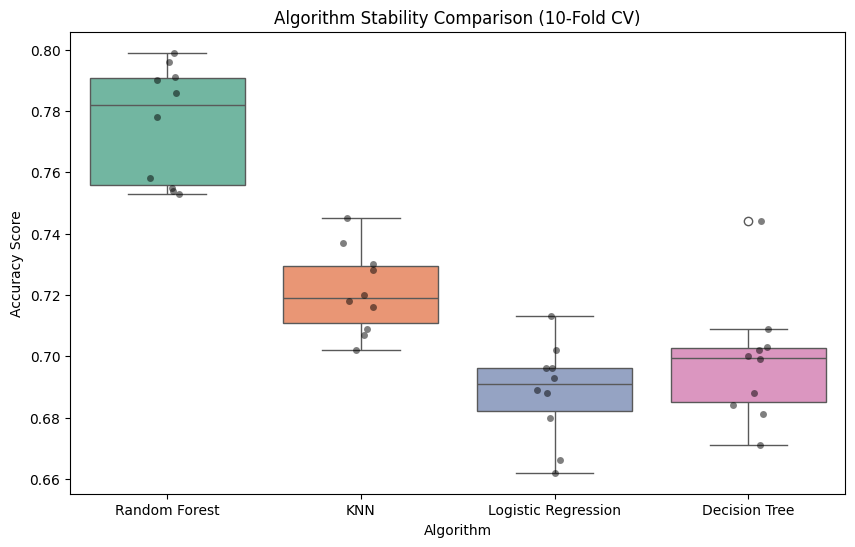

In [ ]:
# --- CELL 4: STATISTICAL TEST & VISUALIZATION ---

# 1. Paired T-Test
print("STATISTICAL COMPARISON (Paired T-Test)")
print("Null Hypothesis: There is no significant difference between models (p > 0.05)")
print("-" * 75)

other_models = [m for m in best_models.keys() if m != best_model_name]

for other in other_models:
    t_stat, p_val = stats.ttest_rel(results_raw[best_model_name], results_raw[other])
    significance = "SIGNIFICANT DIFFERENCE" if p_val < 0.05 else "No Significant Difference ❌"
    print(f"{best_model_name} vs {other:<15} | p-value: {p_val:.4f} | {significance}")

# 2. Boxplot
plt.figure(figsize=(10, 6))
df_res = pd.DataFrame(results_raw)
df_melt = df_res.melt(var_name='Algorithm', value_name='Accuracy')

sns.boxplot(x='Algorithm', y='Accuracy', data=df_melt, palette='Set2')
sns.stripplot(x='Algorithm', y='Accuracy', data=df_melt, color='black', alpha=0.5, jitter=True)
plt.title('Algorithm Stability Comparison (10-Fold CV)')
plt.ylabel('Accuracy Score')
plt.show()

DEEP DIVE: Random Forest


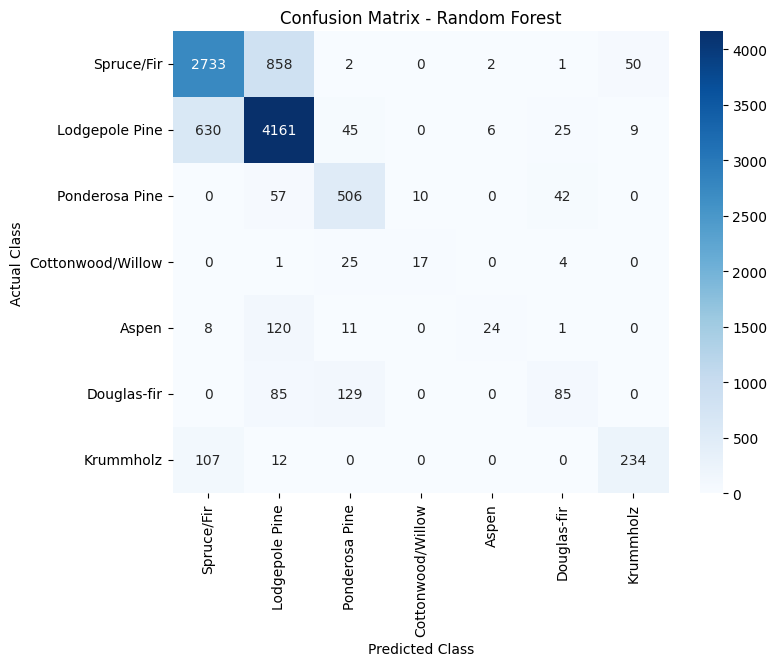


CLASS-WISE PERFORMANCE METRICS:
            Class   TP   FP  FN  Sensitivity (Recall)  Specificity  Precision
       Spruce/Fir 2733  745 913                 0.750        0.883      0.786
   Lodgepole Pine 4161 1133 715                 0.853        0.779      0.786
   Ponderosa Pine  506  212 109                 0.823        0.977      0.705
Cottonwood/Willow   17   10  30                 0.362        0.999      0.630
            Aspen   24    8 140                 0.146        0.999      0.750
      Douglas-fir   85   73 214                 0.284        0.992      0.538
        Krummholz  234   59 119                 0.663        0.994      0.799


In [ ]:
# --- CELL 5: DETAILED ANALYSIS FOR THE BEST MODEL ---

print(f"DEEP DIVE: {best_model_name}")

# Get predictions for the best model
y_pred_best = cross_val_predict(best_models[best_model_name], X, y, cv=cv)

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# 2. Class-based Metrics (Sensitivity, Specificity, etc.)
print("\nCLASS-WISE PERFORMANCE METRICS:")
metrics_list = []
for i, name in enumerate(target_names):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    sens = TP / (TP + FN) if (TP+FN)>0 else 0
    spec = TN / (TN + FP) if (TN+FP)>0 else 0
    prec = TP / (TP + FP) if (TP+FP)>0 else 0

    metrics_list.append({
        'Class': name, 'TP': TP, 'FP': FP, 'FN': FN,
        'Sensitivity (Recall)': round(sens,3), 'Specificity': round(spec,3), 'Precision': round(prec,3)
    })

print(pd.DataFrame(metrics_list).to_string(index=False))

📈 Plotting Learning Curve...


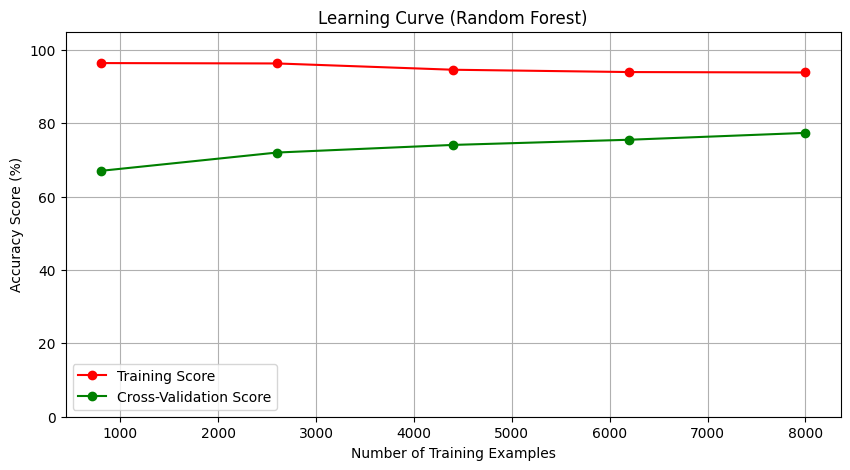


📊 Analyzing Feature Importance...


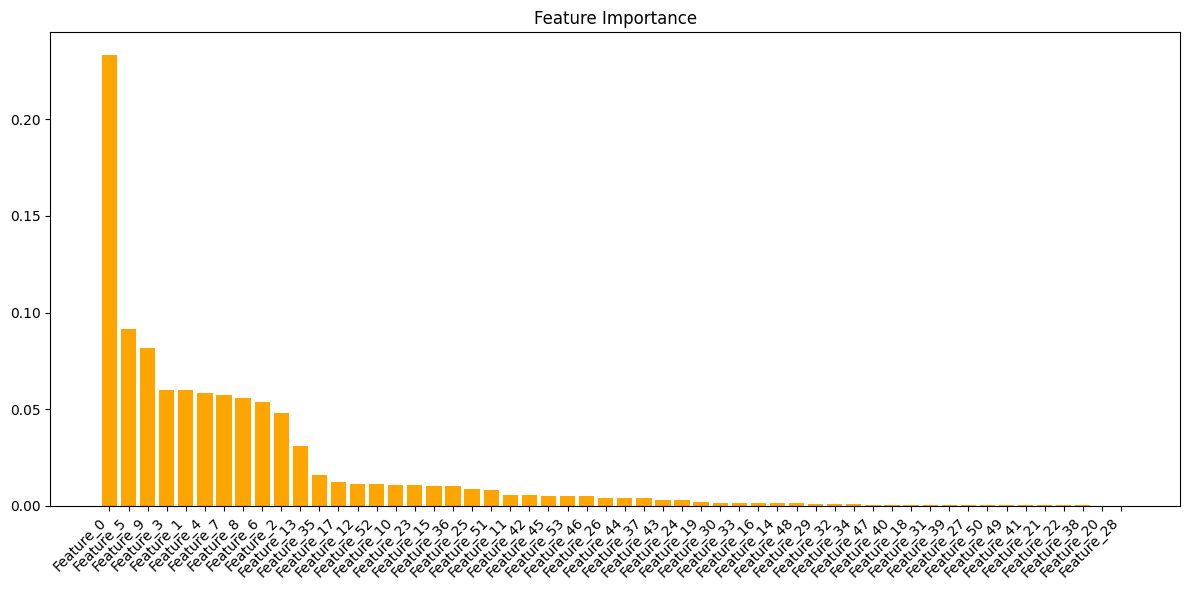

In [ ]:
# --- CELL 6: DIAGNOSTIC PLOTS (LEARNING CURVE & FEATURE IMPORTANCE) ---
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# 1. Learning Curve Function (GÜNCELLENDİ)
def plot_learning_curve_graph(estimator, title, X, y):
    # Cross-validation ile skorları hesapla
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

    # Skorları ortalama al ve YÜZDEYE ÇEVİR (* 100)
    train_mean = np.mean(train_scores, axis=1) * 100
    test_mean = np.mean(test_scores, axis=1) * 100

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.title(title)
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Accuracy Score (%)") # Etiketi yüzde olarak güncelledik

    # --- BURASI EKLENDİ ---
    plt.ylim(0, 105)  # Dikey ekseni 0 ile 105 arasına sabitledik (100'ü rahat göstersin diye 105)
    # ----------------------

    plt.legend(loc="best")
    plt.grid()
    plt.show()

print("📈 Plotting Learning Curve...")
# Not: best_models, best_model_name, X ve y önceki hücrelerden gelmelidir.
plot_learning_curve_graph(best_models[best_model_name], f"Learning Curve ({best_model_name})", X, y)


# 2. Feature Importance (Analysis on Raw Data without PCA)
print("\n📊 Analyzing Feature Importance...")

# Train a pure Random Forest (no PCA) to see original feature names
rf_raw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_raw.fit(X, y)
importances = rf_raw.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='orange')
# feature_names değişkeninin önceki hücrelerde tanımlı olduğundan emin olun
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Plotting ROC Curves (Validasyon Seti Üzerinden)...


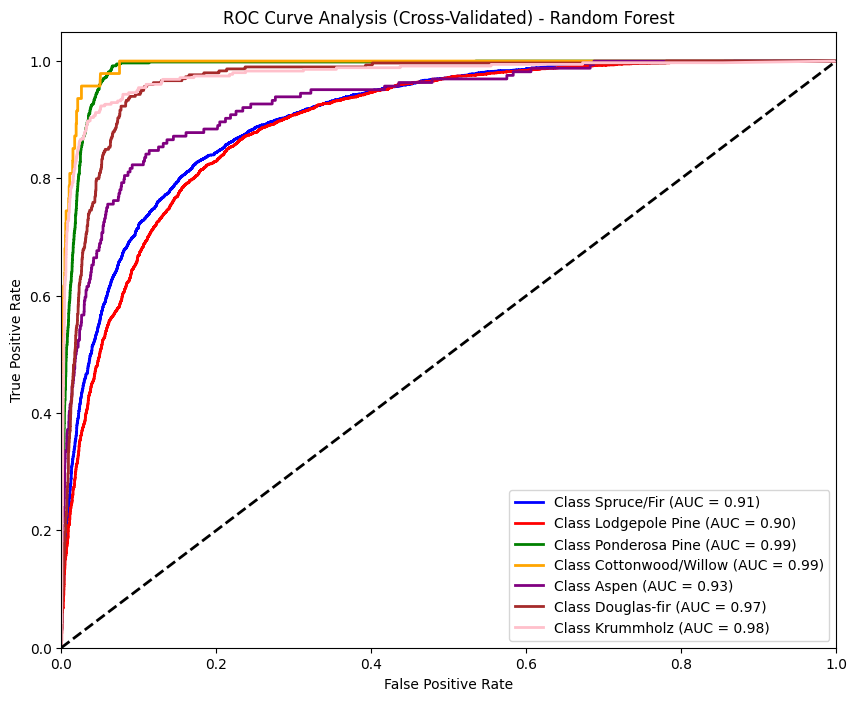

In [ ]:
# --- CELL 7: ROC-AUC CURVES (DÜZELTİLMİŞ - BİLİMSEL VERSİYON) ---
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

print("Plotting ROC Curves (Validasyon Seti Üzerinden)...")

# 1. Veriyi Binarize Et
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# 2. EN ÖNEMLİ KISIM: Cross Validation ile Tahmin Al
# Modelin eğitim sırasında görmediği verilerle tahmin üretiyoruz.
# method='predict_proba' bize olasılıkları verir.
y_score = cross_val_predict(best_models[best_model_name], X, y, cv=5, method='predict_proba')

# 3. Eğrileri Çiz
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'Class {target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve Analysis (Cross-Validated) - {best_model_name}')
plt.legend(loc="lower right")
plt.show()